# HiRISENet-Tiny

A tiny neural network classifier for Mars HiRISE images

## Introduction

The Mars HiRISE (High Resolution Imaging Science Experiment) [[1]](#1) is a camera on board the Mars Reconnaissance
Orbiter which has been orbiting and studying Mars since 2006. A product of this payload's years of service has been the
curation of the Mars orbital image (HiRISE) labeled data set [[2]](#2) by NASA. This dataset provides a curated set of
labelled images of the Martian terrain from an orbital perspective. **Figure 1** shows one of the first images taken
with the HiRISE camera.

<!--- Public Domain, https://commons.wikimedia.org/w/index.php?curid=656514 >
--->
![First HiRISE Image](../assets/images/mro_first_image.jpg "Figure 1. The first orbital image captured by HiRISE")

**Figure 1. Crop of one of the first images of Mars from the HiRISE camera.**

In 2018, Wagstaff et. al. [[3]](#3) set out to train a deep learning model to enable scientists & researchers to conduct
advanced queries of the HiRISE data in NASA's planetary imagery database. With the first edition of the dataset, the
authors fine-tuned the AlexNet convolutional neural network on the data. This initial dataset contained 3,820 
greyscale images and consisted of the labels crater, dark dune, bright dune, dark slope streak, other and edge. With
this dataset, the model achieved 99.1%, 88.1%, and 90.6% accuracy across their training, validation, and test sets
respectively.

Following this effort, Wagstaff et. al. published a follow up paper [[4]](#4) which expanded the initial dataset to
a version 3.2. This expanded dataset consists of a total of 64,947 landmark images. These images have been preprocessed
and cropped to a 227x227 size similar to the first edition. In v3.2, a subset of these images, 9,022, were augmented 
using a variety of image augmentation techniques applied individually to the subset of images. This artificially
expanded the available data. The authors also introduced the classes impact ejecta, spiders, and swiss cheese while
removing edge.

![HiRISE v3.2 Class Imagse](../assets/images/hirise_v3_classes.png)

The authors also fine-tuned the AlexNet model on the new dataset. For this iteration, the authors analyzed the model's
confidence and utilized calibration techniques to make the model more reliable. With this approach and improved dataset,
the authors managed to improve the model's classification accuracy to
{"train": 99.6%, "val": 88.6%, "test": 92.8%}.

![Dataset Class Distribution](../assets/images/hirise_dataset_class_distribution.png)

An important thing to note is that the class distribution is pretty unbalanced. Images of "Other" significantly
dominate the dataset while "Impact Ejecta" constitutes a small portion of the dataset.

### About this Project

In this project I challenged myself to develop a pipeline for training and
deployment of a neural network to run on the NVIDIA Jetson Nano 2GB. This neural
network shall be able to classify the greyscale HiRISE images.

My goal is to train a modern convolutional neural network that is more resource
efficient than AlexNet and, hopefully, as good as the author's trained AlexNet.

As a flight software engineer, I am focused on creating a trusted model that is
also resource efficient. As part of this project I also want to analyze and
evaluate the resource utilization and performance of the model.

Previous work by Dunkel et. al. [[5]](#5) provides some clues as to metrics
machine learning practitioners should be cognisant of for a space-based
environment. Based on the information the authors provided, I have derived some
requirements that outline metrics I will be collecting.

Key metrics I would like to collect include:

* Inference time of the model on a single input image
* Peak RAM utilization of the model
* Disk utilization of the model
* Energy consumption of the model

#### Requirements

| Requirement | Description                                                                                    | Description                                           | Verification Method |
|-------------|------------------------------------------------------------------------------------------------|-------------------------------------------------------|---------------------|
| HIRISE-001  | A neural network model shall be trained on the HiRISE v3.2 dataset.                            | The goal of the project is to classify HiRISE images. | Test Set Evaluation |
| HIRISE-002  | A neural network model shall achieve a minimum of 80% accuracy on the test dataset.            | The model needs to be nearly as good as AlexNet.      | Test Set Evaluation |
| HIRISE-003  | A neural network model shall execute on the NVIDIA Jetson Nano 2GB.                            | The flight software board is the NVIDIA Jetson Nano.  | Inspection          |
| HIRISE-004  | A neural network model inference time shall not exceed 1,069 ms on the NVIDIA Jetson Nano CPU. | The existing benchmark for HiRISENet is 1,069 ms.     | Profiling Test      |
| HIRISE-005  | A neural network model inference time shall not exceed 234 ms on the NVIDIA Jetson Nano GPU.   | The existing benchmark for HiRISENet is 234 ms.       | Profiling Test      |
| HIRISE-006  | A neural network energy consumption shall not exceed 10.7 J on the NVIDIA Jetson Nano CPU.     | The existing benchmark for HiRISENet is 10.7 J.       | Profiling Test      |
| HIRISE-007  | A neural network energy consumption shall not exceed 2.3 J on the NVIDIA Jetson Nano CPU.      | The existing benchmark for HiRISENet is 2.3 J.        | Profiling Test      |
| HIRISE-008  | A neural network model parameter size shall not exceed 233 MB.                                 | AlexNet in PyTorch 2.5 is ~233 MB in size.            | Profiling Test      |

------------------------------

## Setup

Lets get some basic project infrastructure set up first.

In [1]:
import sys

sys.path.append("data")
sys.path.append("utils")

In [2]:
import torch
from utils.gpu_management import GPUManager

from data.dataset import HiRISE
from data.split_type import SplitType
import torchvision
from torchvision.transforms import v2
from pathlib import Path
from model.adapt import (
    get_modified_alexnet,
    get_modified_resnet18,
    get_modified_efficientnet_b0,
    get_modified_efficientnet_v2_s,
    get_modified_convnext_tiny,
)
from model.insights import (
    plot_model_sizes,
    plot_model_flops,
    plot_model_macs,
    plot_cpu_execution_time,
    plot_max_mem_usage,
)

torch.manual_seed(42)

device = GPUManager.enable_gpu_if_available()

if device.type == "cuda":
    GPUManager.cleanup_gpu_cache()

__CUDA VERSION: 90100
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA RTX A2000 8GB Laptop GPU
__CUDA Device Total Memory [GB]: 8.58947584


### Exploratory Data Analysis

The first thing we should do is gain a deep understanding of our dataset. As
mentioned in the introduction, the model we train is a direct reflection of our
data. That is, the model _is_ the data.

The HiRISE v3.2 [[2]](#2) dataset has the following characteristics:

* **Number of Classes:** The dataset comprises of 8 different classes, each representing different Martian terrain features: bright dune, crater, dark dune, impact ejecta, other, slope streak, spider, swiss cheese.

* **Images:** The dataset contains 64,947 227x227 images. The images have been pre-processed and a subset of the original images were augmented with the following transformations: 90° clockwise rotation, 180° clockwise rotation, 270° clockwise rotation, horizontal flip, vertical flip, random brightness adjustment.

* **File Format:** The images are stored in JPG format.

* **Directory Structure:** The data has been split by the authors into a training, validation, and test split.

Before we can feed our dataset into a model, we need to transform it into a
format that the model can understand. For this, we use the `transforms` module
from `torchvision`.

In [3]:
image_size: tuple = (227, 227)

data_transforms = {
    "train": v2.Compose(
        [
            v2.Resize(image_size),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            # v2.RandomRotation(degrees=10),
            # v2.RandomHorizontalFlip(),
            # v2.RandomVerticalFlip()
        ]
    ),
    "val": torchvision.transforms.v2.Compose(
        [v2.Resize(image_size), v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]
    ),
    "test": torchvision.transforms.v2.Compose(
        [v2.Resize(image_size), v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]
    ),
}

At this point, the transforms we use are pretty standard for image data.
We first resize each image to 227x227. The images should already be this size
but you can never be too careful. The `v2.ToImage()` and `v2.ToDtype(...)`
are the new PyTorch v2 recommended way of transforming an image to a tensor.
The old `ToTensor()` is deprecates as of this writing.

Lastly, the `v2.Normalize()` transformation normalizes the tensor image. The
values are simply the midpoint of [0.0, 1.0].
Normalization helps improve the convergence speed and overall performance of
the model.

In [4]:
data_folder: Path = Path("/tmp/.hirise")

train_dataset = HiRISE(
    root_dir=data_folder,
    split_type=SplitType.TRAIN,
    transform=data_transforms["train"],
    target_transform=lambda data: torch.tensor(data, dtype=torch.long),
    download=True,
)

val_dataset = HiRISE(
    root_dir=data_folder,
    split_type=SplitType.VAL,
    transform=data_transforms["val"],
    target_transform=lambda data: torch.tensor(data, dtype=torch.long),
    download=True,
)

test_dataset = HiRISE(
    root_dir=data_folder,
    split_type=SplitType.TEST,
    transform=data_transforms["test"],
    target_transform=lambda data: torch.tensor(data, dtype=torch.long),
    download=True,
)

Now that we have our datasets, lets see what these images actually look like.
Lets plot one of each class.

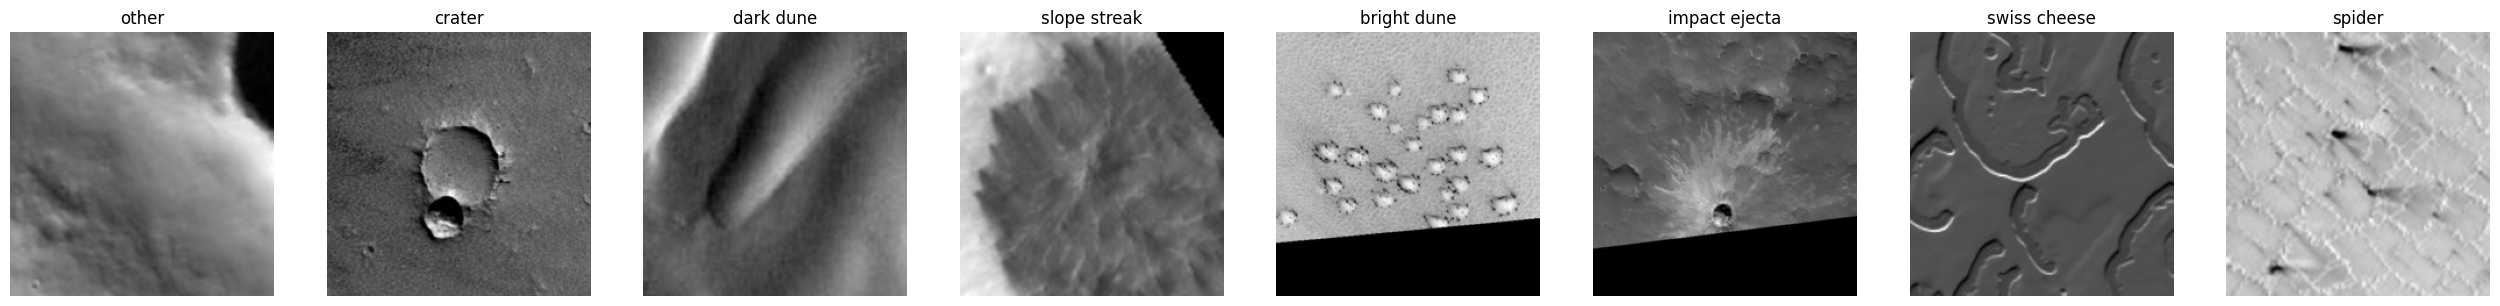

In [5]:
train_dataset.show_image_per_class()

From the images we show, it's clear that some of these terrains are very
similar to each other. Two particular classes that stand out to me are the
crater and impact ejecta. They both look like craters with the distinguishing
feature being the brighter material surrounding the impact crater. 

It also seems like a crater in this dataset is an impact zone that is larger
than an impact ejecta image. So then, what if the impact ejecta has been covered
or eroded in the image? I wonder if the model will have some difficulties with
that.

As mentioned by the authors of the dataset, the "other" class is a catch-all
class to capture anything that doesn't quite fit into the other classes. They
also mention that this "other" class makes up the overwhelming majority of the
data.

Lets take a look at that now.

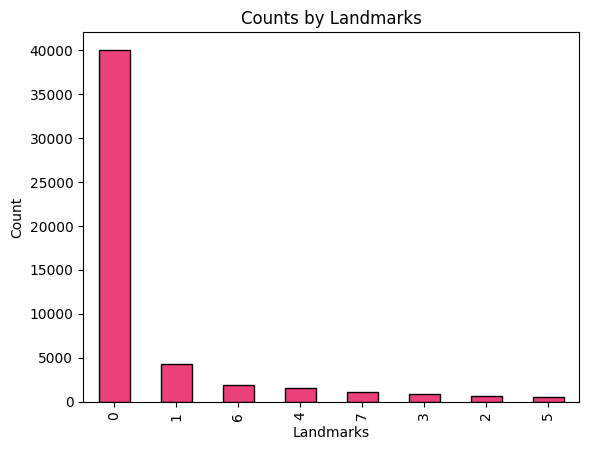

In [6]:
train_dataset.show_class_distribution()

From the distribution plot we can see that the "Other" landmarks significantly
dominate the class distribution. This clear imbalance of data will need to be
accounted for in our model training.

### Selecting Our Models

We will now select a group of model architectures that we will train on our
HiRISE dataset. The models will be downloaded straight from PyTorch and we will
use transfer learning by loading the respective model's IMAGENET weights.

Additionally, we will need to modify the model architecture. All of the
selected models were originally trained on IMAGENET. That means that they all
expect multi-channel image input to predict 1,000 classes. For our dataset we
need the models to expect single-channel input images and predict only 8
classes.

#### AlexNet

The first model architecture we will consider is AlexNet. The authors of the
HiRISE dataset used transfer learning to train this model on the dataset.
Therefore, it is only natural that we incorporate it into our experiments as
well.

In [7]:
models = dict()  # lets track our model in a dictionary

In [8]:
models["alexnet"] = get_modified_alexnet()

#### ResNet

The next model architecture we will use transfer learning on is ResNet18. This
is a tried-and-true model architecture that serves as a great baseline.
Sometimes all you need is good ol' ResNet.

In [9]:
models["resnet18"] = get_modified_resnet18()

#### EfficientNet

Another model architecture we will consider is the EfficientNet and
EfficientNet v2 family. These are more modern and efficient architectures that
are better suited for mobile and edge deployment.

In [10]:
models["efficientnet_b0"] = get_modified_efficientnet_b0()

In [11]:
models["efficientnet_v2_s"] = get_modified_efficientnet_v2_s()

#### ConvNeXt

The last neural network architecture we will consider is ConvNeXt. This is a
fairly modern architecture that was inspired by the recent success of vision
transformers.

In [12]:
models["convnext_tiny"] = get_modified_convnext_tiny()

### Characterizing Model Performance

With our model architectures selected and modified for HiRISE, we are now ready
to do some profiling. To meet our project requirements, we must characterize
the following metrics:
- Model size
- FLOPS
- Inference latency
- Memory utilization
- Energy usage

#### Model Sizes

Lets kick things off my measuring the size of our models. This is an important
metric to measure given that a lot of spacecraft are very resource constrained.

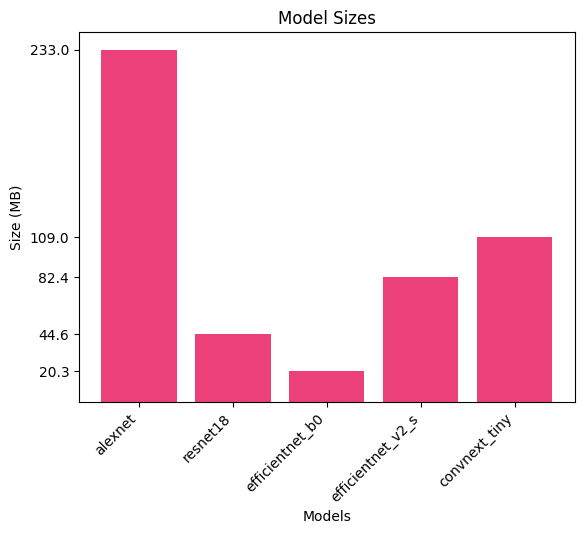

In [13]:
plot_model_sizes(models)

As we can see, the models we have selected do not exceed our HIRISE-008
requirement. This is great! 

#### FLOPS

Next, lets calculate the number of floating-point operations (FLOPS) that our
model executes. FLOPS are an important metric to capture as they provide some
insights into the computational and energy requirements of the model.
Additionally for spacecraft flight software, a couple of general rules of thumb
for deploying math-intensive applications include:

- The less math the better. Especially multiplication.
- Beware of division by zero. Protect against it at all costs!

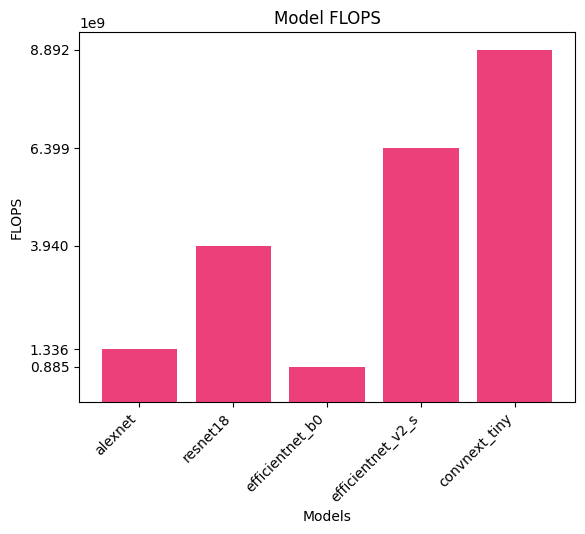

In [14]:
plot_model_flops(models)

As we can see from the plot, AlexNet is one of the model architectures with
the least amount of FLOPS. 

#### MACs

Multiply Accumulate

/root/.conda/envs/hirisenet/lib/python3.12/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::silu_". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/root/.conda/envs/hirisenet/lib/python3.12/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::empty". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/root/.conda/envs/hirisenet/lib/python3.12/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::bernoulli_". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/root/.conda/envs/hirisenet/lib/python3.12/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::silu_". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/root/.conda/envs/hirisenet/lib/python3.12/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::empty". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.

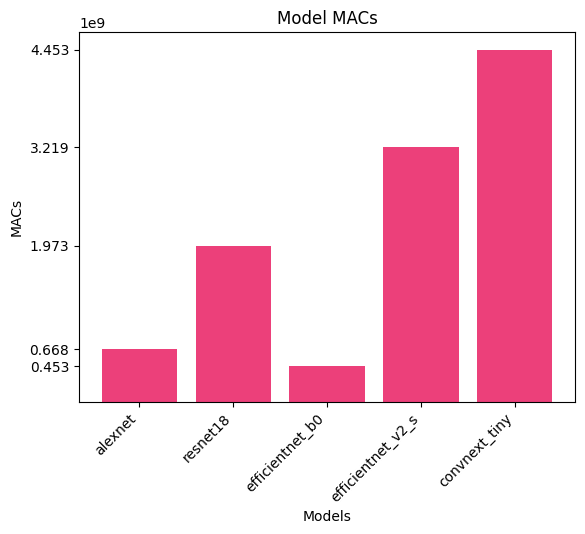

In [16]:
plot_model_macs(models)

#### Execution Time

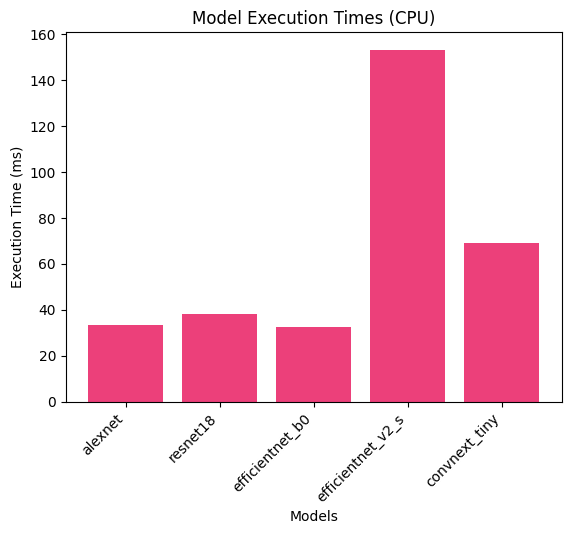

In [17]:
plot_cpu_execution_time(models)

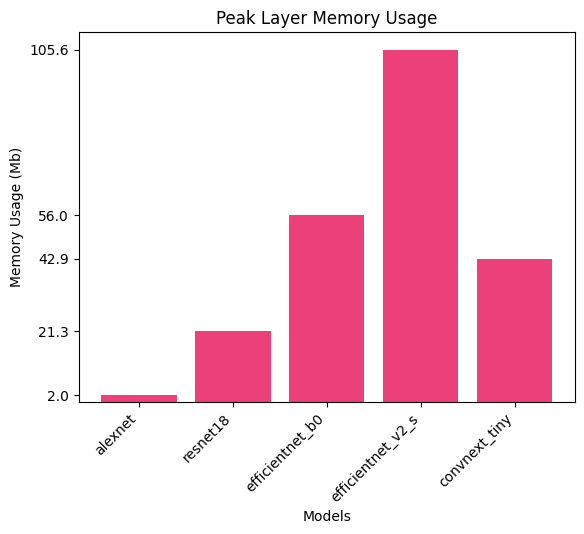

In [18]:
plot_max_mem_usage(models)

In [ ]:
from codecarbon import EmissionsTracker

# tracker = EmissionsTracker()

In [ ]:
models["efficientnet_v2_s"].to(device)
models["efficientnet_v2_s"].eval()
test_tensor = torch.randn((1, 1, 227, 227), device=device)


with EmissionsTracker() as tracker:
    models["efficientnet_v2_s"](test_tensor)
# tracker.start()

# # Your PyTorch model execution
# models["efficientnet_v2_s"](test_tensor)

# emissions: float = tracker.stop()
# print(emissions)

# tracker.flush()

### Setting Up Our Training Loop

With our model downloaded, modified and prepared, we are ready to jump into
training and establishing a baseline. First, we'll setup some hyperparameters
for this round of training.

In [ ]:
LEARNING_RATE: float = 1e-3
BATCH_SIZE: int = 128
EPOCHS: int = 10

We'll also need to create a couple of `DataLoader` objects to easily iterate
over our datasets.

In [ ]:
dataloaders = {
    name: torch.utils.data.DataLoader(
        dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True
    )
    for name, dataset in zip(
        ["train", "val", "test"], [train_dataset, val_dataset, test_dataset]
    )
}

For the loss function we will use `CrossEntropyLoss`. This is a fairly standard
loss function and is commonly used in machine learning. Similarly, the `Adam`
optimizer is standard and pretty foolproof.

In [ ]:
dataset_sizes = {
    name: len(dataset)
    for name, dataset in zip(
        ["train", "val", "test"], [train_dataset, val_dataset, test_dataset]
    )
}
dataset_sizes

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params=models["resnet18"].parameters(), lr=LEARNING_RATE, weight_decay=)
optimizer = torch.optim.SGD(params=models["efficientnet_b0"].parameters(), lr=0.0005)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

In [ ]:
# To freeze layers, we set the requires_grad attribute to False. This prevents
# PyTorch from calculating the gradients for these layers during
# backpropagation.
# for param in models["resnet18"].parameters():
#     param.requires_grad = False

# # Unfreeze last layer
# for param in models["resnet18"].fc.parameters():
#     param.requires_grad = True

#### Fully Training AlexNet

In this section we will use transfer learning to train AlexNet on our dataset.
We will **not** be freezing the model layers.

In [ ]:
from model.training import train_model

alexnet_ft, alexnet_ft_history = train_model(
    models["efficientnet_b0"],
    dataloaders,
    criterion,
    optimizer,
    exp_lr_scheduler,
    device,
    num_epochs=EPOCHS,
)

-------------------------------------

## References

<a id="1">[1]</a> 
Wikipedia contributors. (2024, November 19). HiRISE. Wikipedia. https://en.wikipedia.org/wiki/HiRISE

<a id="2">[2]</a> 
Gary Doran, Emily Dunkel, Steven Lu, & Kiri Wagstaff. (2020). Mars orbital image (HiRISE) labeled data set version 3.2 (3.2.0) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.4002935

<a id="3">[3]</a>
Wagstaff, K., Lu, Y., Stanboli, A., Grimes, K., Gowda, T., & Padams, J. (2018). Deep Mars: CNN Classification of Mars Imagery for the PDS Imaging Atlas. Proceedings of the AAAI Conference on Artificial Intelligence, 32(1). https://doi.org/10.1609/aaai.v32i1.11404

<a id="4">[4]</a>
Wagstaff, Kiri, et al. Mars Image Content Classification: Three Years of NASA Deployment and Recent Advances. arXiv:2102.05011, arXiv, 9 Feb. 2021. arXiv.org, https://doi.org/10.48550/arXiv.2102.05011.

<a id="5">[5]</a>
Dunkel, Emily R., et al. “Benchmarking Deep Learning Models on Myriad and Snapdragon Processors for Space Applications.” Journal of Aerospace Information Systems, vol. 20, no. 10, Oct. 2023, pp. 660–74. DOI.org (Crossref), https://doi.org/10.2514/1.I011216.

<a id="6">[6]</a>
He, Kaiming, et al. Deep Residual Learning for Image Recognition. arXiv:1512.03385, arXiv, 10 Dec. 2015. arXiv.org, https://doi.org/10.48550/arXiv.1512.03385.

<a id="7">[7]</a>
Tan, Mingxing, and Quoc V. Le. EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks. arXiv:1905.11946, arXiv, 11 Sept. 2020. arXiv.org, https://doi.org/10.48550/arXiv.1905.11946.

<a id="8">[8]</a>
Liu, Zhuang, et al. A ConvNet for the 2020s. arXiv:2201.03545, arXiv, 2 Mar. 2022. arXiv.org, https://doi.org/10.48550/arXiv.2201.03545.
